# Getting started with transforms v2

In [2]:
from pathlib import Path
import os
import sys
import torch
import matplotlib.pyplot as plt

plt.rcParams["savefig.bbox"] = 'tight'

from torchvision.transforms import v2
from torchvision.io import decode_image

sys.path.append("..")
torch.manual_seed(1)

# If you're trying to run that on Colab, you can download the assets and the
# helpers from https://github.com/pytorch/vision/tree/main/gallery/
from helpers import plot


In [3]:
img_id = 54
img = decode_image(str(os.path.join('/media/miked/Elements/Judge/FINISHED-DB-READY/images', f"{img_id}.jpg")))
print(f"{type(img) = }, {img.dtype = }, {img.shape = }")

type(img) = <class 'torch.Tensor'>, img.dtype = torch.uint8, img.shape = torch.Size([3, 720, 1280])


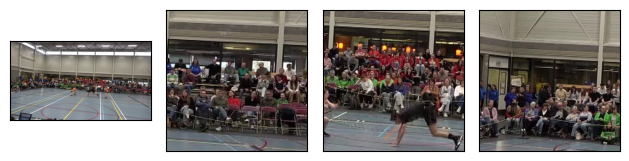

In [4]:
transform = v2.RandomCrop(size=(224, 224))
out1 = transform(img)
out2 = transform(img)
out3 = transform(img)


plot([img, out1, out2, out3])

In [5]:
img


tensor([[[ 16,  14,  14,  ...,  61,  60,  60],
         [ 21,  17,  12,  ...,  60,  59,  59],
         [ 86,  90,  92,  ...,  60,  59,  59],
         ...,
         [ 31,  39,  33,  ..., 105, 109, 109],
         [ 34,  32,  33,  ..., 112, 108, 107],
         [ 34,  19,  33,  ..., 123, 120, 117]],

        [[ 12,  10,  10,  ...,  56,  55,  55],
         [ 17,  13,   8,  ...,  55,  54,  54],
         [ 82,  86,  88,  ...,  55,  54,  54],
         ...,
         [ 28,  36,  30,  ...,  76,  80,  80],
         [ 29,  27,  30,  ...,  77,  73,  72],
         [ 29,  14,  30,  ...,  85,  80,  77]],

        [[ 11,   9,   9,  ...,  53,  52,  52],
         [ 16,  12,   7,  ...,  52,  51,  51],
         [ 83,  87,  89,  ...,  52,  51,  51],
         ...,
         [ 21,  29,  23,  ...,  94, 100,  98],
         [ 23,  21,  23,  ...,  99,  97,  94],
         [ 23,   8,  23,  ..., 110, 106, 103]]], dtype=torch.uint8)

In [6]:
%pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


## Loading from video

Using cv2, as pytorch video api is time based and not frame based (to set specific frame)

In [7]:
import cv2
def get_frames(path, frameNrs, keepWrongBGRColors=True):
    frames = {}
    cap = cv2.VideoCapture(path)
    for frameNr in frameNrs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, frameNr)
        _, frame = cap.read()
        frame = frame if keepWrongBGRColors else cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames[frameNr] = frame

    cap.release()

    return frames

In [8]:
videopath = "/media/miked/Elements/Judge/FINISHED-DB-READY/competition/belgium/DD3/bk-sipiro-dd3-2024-senioren-luka-j1.MP4"

In [9]:
frames = get_frames(videopath, [3, 555], keepWrongBGRColors=False)

In [10]:
torch_image = torch.from_numpy(frames[555]).permute(2, 0, 1)

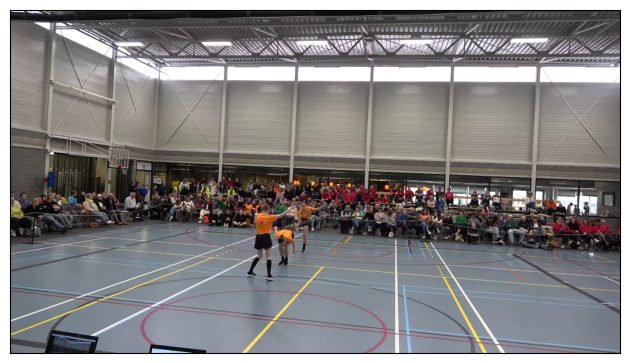

In [11]:
plot([torch_image])

## Loading image with border

In [20]:
from torchvision.transforms.v2.functional import crop
import sqlalchemy
import pandas as pd


In [21]:
def get_connection():
    HOST = '127.0.0.1'
    PORT = '3377'
    DATABASE = 'judge'
    USERNAME = 'root'
    PASSWORD = 'root'
    DATABASE_CONNECTION=f"mysql+pymysql://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"
    engine = sqlalchemy.create_engine(DATABASE_CONNECTION)#
    return engine.connect()

In [22]:
con = get_connection()

In [54]:
qry = "SELECT * FROM FrameLabels WHERE videoId = 101"
videopath = "/media/miked/Elements/Judge/FINISHED-DB-READY/competition/belgium/DD3/bk-sipiro-dd3-2024-junioren-lore-j1.MP4"
width = 1280
height = 720
df = pd.read_sql_query(qry, con)
df = df.sample(frac=1.)
df.head()

,videoId,frameNr,x,y,width,height,jumperVisible
56,101,894,0.453878,0.704644,0.217143,0.442671,1
102,101,1768,0.420000,0.714804,0.221224,0.451379,1
104,101,1795,0.420816,0.732221,0.231020,0.465893,1
6,101,57,0.472245,0.668360,0.381224,0.355588,1
87,101,1488,0.413061,0.730044,0.212245,0.423803,1


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107 entries, 56 to 60
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   videoId        107 non-null    int64  
 1   frameNr        107 non-null    int64  
 2   x              107 non-null    float64
 3   y              107 non-null    float64
 4   width          107 non-null    float64
 5   height         107 non-null    float64
 6   jumperVisible  107 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 6.7 KB


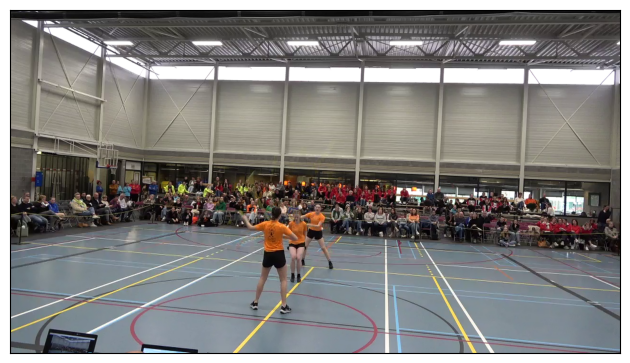

In [82]:
frames = get_frames(videopath, df["frameNr"].iloc[0:1], keepWrongBGRColors=False)
frames = [v for v in frames.values()]
plot(frames)

In [83]:
info = df.iloc[0]
info.x * width, info.y * height, info.width * width, info.height * height

(np.float64(580.96384),
 np.float64(507.34368000000006),
 np.float64(277.94304),
 np.float64(318.72312))

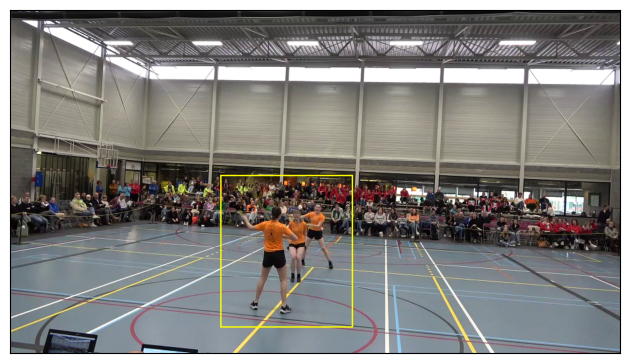

In [ ]:
from torchvision import tv_tensors  # we'll describe this a bit later, bare with us
import torchvision

img = frames[0]
torch_image = torch.from_numpy(img).permute(2, 0, 1)
boxes = tv_tensors.BoundingBoxes(
    [
        [info.x * width, info.y * height, info.width * width, info.height * height],     
        # [200.55,200,200,200]
    ],
    format="CXCYWH", canvas_size=torch_image.shape[-2:])
boxes_xyxy = torchvision.ops.box_convert(boxes, in_fmt="cxcywh", out_fmt="xyxy")
non_tensor = tv_tensors.BoundingBoxes(boxes_xyxy, format="XYXY", canvas_size=torch_image.shape[-2:])

plot([(torch_image, non_tensor)])

In [88]:
torch_image.shape[-2:]

torch.Size([720, 1280])